In [1]:
import numpy as np
import torch

import matplotlib.pyplot as plt

import sys
sys.path.append("../../")

import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(1)

In [2]:
models = torch.load("model/ham_activation.pt")

hamODE_tanh, hamODE_sigmoid, hamODE_relu, hamODE_softplus = models

hamODE_tanh.eval()
hamODE_sigmoid.eval()
hamODE_relu.eval()
hamODE_softplus.eval()

None

In [3]:
test_set = torch.load('data/SHM_test_set.pt')
train_set = torch.load('data/SHM_training_set.pt')[:300]

### Get test err

In [4]:
test_err = []
train_err = []
test_t_span = test_set[0, :, -1]
train_t_span = train_set[0, :, -1]

for model in models:
    test_traj = model.trajectory(test_set[:, 0, 0:2], test_t_span).transpose(0,1)
    test_loss = torch.nn.functional.mse_loss(test_traj, test_set[:, :, 0:2])
    
    train_traj = model.trajectory(train_set[:, 0, 0:2], train_t_span).transpose(0,1)
    train_loss = torch.nn.functional.mse_loss(train_traj, train_set[:, :, 0:2])
    
    test_err.append(test_loss)
    train_err.append(train_loss)

In [14]:
for i in range(4):
    print(train_err[i])
    print(test_err[i])

tensor(2.2729e-06, grad_fn=<MseLossBackward>)
tensor(63.5900, grad_fn=<MseLossBackward>)
tensor(1.8037e-06, grad_fn=<MseLossBackward>)
tensor(67.7768, grad_fn=<MseLossBackward>)
tensor(0.0045, grad_fn=<MseLossBackward>)
tensor(25.4360, grad_fn=<MseLossBackward>)
tensor(2.9993e-06, grad_fn=<MseLossBackward>)
tensor(23.0291, grad_fn=<MseLossBackward>)


epoch till converge
5835
3614
5977
690
4292

### Phase Portrait

In [31]:
test_model = models[3]

In [32]:
with torch.no_grad():
    n_grid = 100
    x = torch.linspace(-5.5, 5.5, n_grid)
    Q, dQ = torch.meshgrid(x, x)  # all (q, p)

    H, U, V = torch.zeros(Q.shape), torch.zeros(Q.shape), torch.zeros(Q.shape)

    for i in range(n_grid):
        for j in range(n_grid):
            x = torch.cat([Q[i, j].reshape(1, 1), dQ[i, j].reshape(1, 1)], 1)
            H[i, j] = test_model.defunc.m.H(x)
            grad = test_model.defunc(0, x).detach().cpu()
            U[i, j], V[i, j] = grad[:, 0], grad[:, 1]

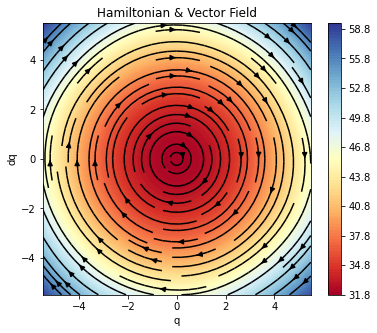

In [33]:
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
CS = ax.contourf(Q, dQ, H, 100, cmap='RdYlBu')
fig.colorbar(CS)

ax.streamplot(Q.T.numpy(), dQ.T.numpy(), U.T.numpy(), V.T.numpy(), color='black')

ax.set_xlim([Q.min(), Q.max()])
ax.set_ylim([dQ.min(), dQ.max()])
ax.set_xlabel("q")
ax.set_ylabel("dq")
ax.set_title("Hamiltonian & Vector Field")
None

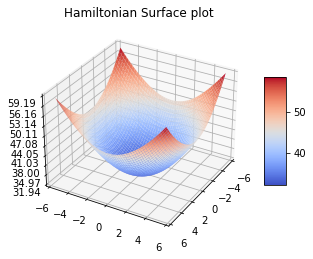

In [34]:
# Plot the surface
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax.plot_surface(Q.numpy(), dQ.numpy(), H.numpy(), cmap='coolwarm')

# Customize the z axis.
ax.set_zlim(H.min(), H.max())
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.02f}')
ax.view_init(30, 30)

ax.set_title("Hamiltonian Surface plot")

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

None

### Trajectory Test

In [35]:
from utils import SHM_1D_model

In [36]:
# Generate Trajectory from true model
t0 = 0
dt = 0.05
steps = 200
t1 = int(dt * steps)

q_p1, dq_dp, _, ts = SHM_1D_model(x0=1.5, p0=1.5, t0=t0, t1=t1, steps=steps)
q_p2, dq_dp, _, ts = SHM_1D_model(x0=4, p0=4, t0=t0, t1=t1, steps=steps)


# Generate Estimated Trajectory
t_span = torch.linspace(t0, t1, steps)

traj1_tanh = models[0].trajectory(q_p1[[0], :], t_span).detach()  # (time, points, dim)
traj1_sigmoid = models[1].trajectory(q_p1[[0], :], t_span).detach()  # (time, points, dim)
traj1_relu = models[2].trajectory(q_p1[[0], :], t_span).detach()  # (time, points, dim)
traj1_softplus = models[3].trajectory(q_p1[[0], :], t_span).detach()  # (time, points, dim)

traj2_tanh = models[0].trajectory(q_p2[[0], :], t_span).detach()  # (time, points, dim)
traj2_sigmoid = models[1].trajectory(q_p2[[0], :], t_span).detach()  # (time, points, dim)
traj2_relu = models[2].trajectory(q_p2[[0], :], t_span).detach()  # (time, points, dim)
traj2_softplus = models[3].trajectory(q_p2[[0], :], t_span).detach()  # (time, points, dim)

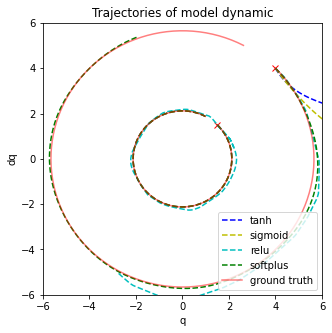

In [37]:
# Plot the trajectory generated from the model
# Phase Plot
fig = plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot(111)

length = 120
ax1.plot(q_p1[0, 0], q_p1[0, 1], marker='x', color="red")  # init pos
ax1.plot(q_p2[0, 0], q_p2[0, 1], marker='x', color="red")  # init pos

ax1.plot(traj1_tanh[:length, 0, 0], traj1_tanh[:length, 0, 1], 'b--', label='tanh')
ax1.plot(traj1_sigmoid[:length, 0, 0], traj1_sigmoid[:length, 0, 1], 'y--', label='sigmoid')
ax1.plot(traj1_relu[:length, 0, 0], traj1_relu[:length, 0, 1], 'c--', label='relu')
ax1.plot(traj1_softplus[:length, 0, 0], traj1_softplus[:length, 0, 1], 'g--', label='softplus')
ax1.plot(q_p1[:length, 0], q_p1[:length, 1], color='red', alpha=0.5, label='ground truth')

ax1.plot(traj2_tanh[:length, 0, 0], traj2_tanh[:length, 0, 1], 'b--')
ax1.plot(traj2_sigmoid[:length, 0, 0], traj2_sigmoid[:length, 0, 1], 'y--')
ax1.plot(traj2_relu[:length, 0, 0], traj2_relu[:length, 0, 1], 'c--')
ax1.plot(traj2_softplus[:length, 0, 0], traj2_softplus[:length, 0, 1], 'g--')
ax1.plot(q_p2[:length, 0], q_p2[:length, 1], color='red', alpha=0.5)

ax1.set_xlim([-6., 6.])
ax1.set_ylim([-6., 6.])
ax1.set_xlabel("q")
ax1.set_ylabel("dq")
ax1.legend(loc='lower right')
ax1.set_title("Trajectories of model dynamic")

None

### s-t v-t plot

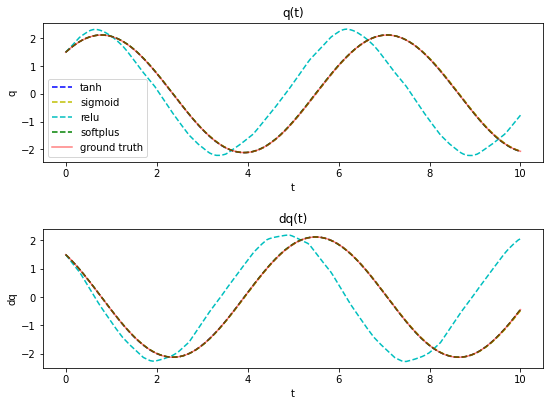

In [45]:
# Plot q(t) and p(t) graph
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(211)


ax1.plot(t_span, traj1_tanh[:, 0, 0], 'b--', label='tanh')
ax1.plot(t_span, traj1_sigmoid[:, 0, 0], 'y--', label='sigmoid')
ax1.plot(t_span, traj1_relu[:, 0, 0], 'c--', label='relu')
ax1.plot(t_span, traj1_softplus[:, 0, 0], 'g--', label='softplus')
ax1.plot(t_span, q_p1[:, 0], color='red', alpha=0.5, label='ground truth')


ax1.set_xlabel("t")
ax1.set_ylabel("q")
ax1.set_title("q(t)")
ax1.legend()

ax2 = fig.add_subplot(212)

ax2.plot(t_span, traj1_tanh[:, 0, 1], 'b--', label='tanh')
ax2.plot(t_span, traj1_sigmoid[:, 0, 1], 'y--', label='sigmoid')
ax2.plot(t_span, traj1_relu[:, 0, 1], 'c--', label='relu')
ax2.plot(t_span, traj1_softplus[:, 0, 1], 'g--', label='softplus')
ax2.plot(t_span, q_p1[:, 1], color='red', alpha=0.5, label='ground truth')

ax2.set_xlabel("t")
ax2.set_ylabel("dq")
ax2.set_title("dq(t)")

fig.tight_layout(pad=2.0)
None

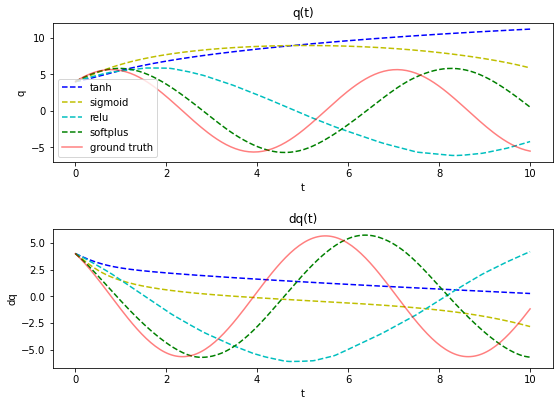

In [44]:
# Plot q(t) and p(t) graph
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(211)


ax1.plot(t_span, traj2_tanh[:, 0, 0], 'b--', label='tanh')
ax1.plot(t_span, traj2_sigmoid[:, 0, 0], 'y--', label='sigmoid')
ax1.plot(t_span, traj2_relu[:, 0, 0], 'c--', label='relu')
ax1.plot(t_span, traj2_softplus[:, 0, 0], 'g--', label='softplus')
ax1.plot(t_span, q_p2[:, 0], color='red', alpha=0.5, label='ground truth')


ax1.set_xlabel("t")
ax1.set_ylabel("q")
ax1.set_title("q(t)")
ax1.legend()

ax2 = fig.add_subplot(212)

ax2.plot(t_span, traj2_tanh[:, 0, 1], 'b--', label='tanh')
ax2.plot(t_span, traj2_sigmoid[:, 0, 1], 'y--', label='sigmoid')
ax2.plot(t_span, traj2_relu[:, 0, 1], 'c--', label='relu')
ax2.plot(t_span, traj2_softplus[:, 0, 1], 'g--', label='softplus')
ax2.plot(t_span, q_p2[:, 1], color='red', alpha=0.5, label='ground truth')

ax2.set_xlabel("t")
ax2.set_ylabel("dq")
ax2.set_title("dq(t)")

fig.tight_layout(pad=2.0)
None